In [2]:
# hack to import local classes
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

from src.models import train_model
from src.data import read_transform
from sklearn.metrics import calinski_harabaz_score

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Read CSR matrix from the input file
csrMatrix = read_transform.csr_read('../data/raw/train.dat')

#Scale the CSR matrix by idf (Inverse Document Frequency)
csrIDF = read_transform.csr_idf(csrMatrix, copy=True)

#Normalize the rows of a CSR matrix by their L-2 norm.
csrL2Normalized = read_transform.csr_l2normalize(csrIDF, copy=True)

#Obtain a dense ndarray representation of the CSR matrix.
denseMatrix = csrL2Normalized.toarray()

In [7]:
csrL2Normalized

<8580x126355 sparse matrix of type '<class 'numpy.float64'>'
	with 1107980 stored elements in Compressed Sparse Row format>

In [12]:
labels = train_model.bisecting_kmeans(denseMatrix, 3, 3)

In [13]:
calinski_harabaz_score(denseMatrix, labels)

48.28809580175584

In [4]:
labels = train_model.bisecting_kmeans(denseMatrix, 7, 10)

In [8]:
pd.DataFrame(labels)[0].value_counts()

5    2035
3    1963
1    1427
6    1075
7    1039
2     675
4     366
Name: 0, dtype: int64

In [6]:
calinski_harabaz_score(denseMatrix, labels)

46.035432919341474

In [9]:
read_transform.write_predictions(labels, '../models/predictions/1.1-am-functional-raw.dat')

In [19]:
pd.DataFrame(csrIDF.todense()).head()

,0,1,2,3,4,5,6,7,8,9,...,126345,126346,126347,126348,126349,126350,126351,126352,126353,126354
0,0.0,0.0,0.000000,8.745455,0.000000,0.295326,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,2.409501,0.590652,0.0,0.0,4.066904,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,1.476629,0.0,0.0,0.813381,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.295326,0.0,0.0,4.066904,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.408205,2.915152,4.819002,0.590652,0.0,0.0,3.253523,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality Reduction

### Term Clustering

Cluster columns instead of rows in order to find term clustering and use those cluster centroids as features to reduce dimensions.

In [20]:
csrL2Normalized.T

<126355x8580 sparse matrix of type '<class 'numpy.float64'>'
	with 1107980 stored elements in Compressed Sparse Column format>

In [21]:
rowLabels = train_model.bisecting_kmeans(csrL2Normalized.T.toarray(), 3, 3)

IndexError: list index out of range

### LDA (Latent Dirichlet Allocation)

In [22]:
from sklearn.decomposition import LatentDirichletAllocation

In [23]:
lda = LatentDirichletAllocation(n_components=1000, random_state=0)

In [24]:
csrL2Normalized_lda = lda.fit_transform(csrL2Normalized)

In [26]:
csrL2Normalized_lda.shape

(8580, 1000)

In [28]:
type(csrL2Normalized_lda)

numpy.ndarray

In [31]:
pd.DataFrame(csrL2Normalized_lda).head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,...,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506,0.000506
1,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,...,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594,0.000594
2,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,...,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628
3,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,...,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395,0.000395
4,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,...,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386,0.000386


In [37]:
csrL2Normalized_lda[:,1:2].shape

(8580, 1)

In [38]:
calinski_harabaz_score(denseMatrix, csrL2Normalized_lda[:,1:2])

/Users/amangal/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3.0650181936705536

In [39]:
labels = train_model.bisecting_kmeans(csrL2Normalized_lda, 3, 3)

In [40]:
calinski_harabaz_score(denseMatrix, labels)

7.380881993582087

### PCA

In [42]:
from sklearn.decomposition import TruncatedSVD

In [43]:
pca = TruncatedSVD(10000)

In [44]:
csrL2Normalized_pca = pca.fit_transform(csrL2Normalized)

KeyboardInterrupt: 

## Outlier Detection

In [3]:
dfDense = pd.DataFrame(denseMatrix)

In [4]:
dfDense[2].head()

0    0.00000
1    0.00000
2    0.00000
3    0.00000
4    0.02532
Name: 2, dtype: float64

/Users/amangal/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


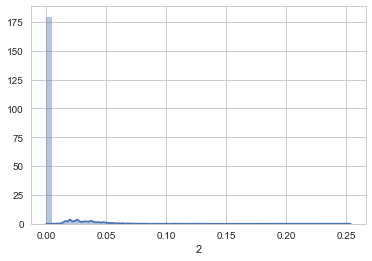

In [5]:
sns.distplot(dfDense[2])

In [6]:
from sklearn.ensemble import IsolationForest

In [7]:
clf = IsolationForest(behaviour='new', random_state=10, contamination='auto', n_jobs=-1)

In [13]:
outl = clf.fit_predict(csrL2Normalized.T)

In [14]:
pd.DataFrame(outl)[0].value_counts()

 1    126261
-1        94
Name: 0, dtype: int64

In [19]:
dfDense.shape

(8580, 126355)

In [21]:
colsToBeRemoved = list()
for idx,out in enumerate(outl):
    if out == -1:
        colsToBeRemoved.append(idx)

In [34]:
denseMatrixWithoutOutliers = np.delete(denseMatrix, colsToBeRemoved, 1)

In [35]:
denseMatrixWithoutOutliers.shape

(8580, 126261)

## Scikit KMeans

In [53]:
from sklearn.cluster import KMeans

In [54]:
def calcSSE(csr, cluster):
    matrix = csr.toarray()
    members = matrix[cluster,:]
    return np.sum(np.square(members - np.mean(members)))

In [80]:
def bisect(csr, k=7, max_iter=10, random_state=10, n_jobs=-1):
    clusters = list()
    initial_clusters = list()
    
    for i in range(csr.shape[0]):
        initial_clusters.append(i)
    
    clusters.append(initial_clusters)
    
    km = KMeans(n_clusters=2, init='k-means++', max_iter=max_iter, random_state=random_state, n_jobs=n_jobs)
    
    parentSSE = list()
    parentSSE.append(calcSSE(csr, initial_clusters))
    
    while len(clusters) <= k :
        minClusterASSE = float("inf")
        minClusterBSSE = float("inf")
        minClusterA = list()
        minClusterB = list()
        minIndex = -1
        for idx, cluster in enumerate(clusters):
            totalParentSSE = parentSSE[idx]
            km.fit(csr)
            clusterA = list()
            clusterB = list()
            for index,clu in enumerate(km.labels_):
                if clu==0:
                    clusterA.append(index)
                else:
                    clusterB.append(index)
            clusterASSE = calcSSE(csr,clusterA)
            clusterBSSE = calcSSE(csr,clusterB)
            
            if clusterASSE + clusterBSSE < minClusterASSE + minClusterBSSE:
                minClusterASSE = clusterASSE
                minClusterBSSE = clusterBSSE
                minIndex = idx
                minClusterA = clusterA
                minClusterB = clusterB
            
        del clusters[minIndex]
        del parentSSE[minIndex]
        
        clusters.append(minClusterA)
        clusters.append(minClusterB)
        parentSSE.append(minClusterASSE)
        parentSSE.append(minClusterBSSE)
    
    labels = np.zeros(csr.shape[0], dtype=np.int)
    for index,cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index+1
    return labels
            

In [6]:
labels = bisect(csrL2Normalized, 3, 3)

KeyboardInterrupt: 

In [ ]:
calinski_harabaz_score(csrL2Normalized.toarray(), labels)

In [56]:
labels = bisect(csrL2Normalized, max_iter=10)

KeyboardInterrupt: 

In [ ]:
calinski_harabaz_score(csrL2Normalized.toarray(), labels)

In [ ]:
read_transform.write_predictions(labels, '../models/predictions/1.1-am-my-bisect.dat')

## Raw KMeans

In [38]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=100, random_state=10, n_jobs=-1)

In [8]:
km.fit(csrL2Normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [9]:
pd.DataFrame(km.labels_)[0].value_counts()

2    4509
1     886
3     764
4     730
6     653
0     616
5     422
Name: 0, dtype: int64

In [10]:
km.inertia_

8005.6821541654535

In [11]:
calinski_harabaz_score(csrL2Normalized.toarray(), km.labels_)

63.97553283559965

In [12]:
read_transform.write_predictions(km.labels_ + 1, '../models/predictions/1.1-am-kmeans-sci.dat')

### Raw kmeans without outliers

In [41]:
csr_without_outliers = csr_matrix(denseMatrixWithoutOutliers)

In [42]:
csr_without_outliers.shape

(8580, 126261)

In [43]:
km.fit(csr_without_outliers)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [44]:
pd.DataFrame(km.labels_)[0].value_counts()

2    5422
0     756
3     683
6     521
4     443
1     426
5     329
Name: 0, dtype: int64

In [45]:
km.inertia_

7662.667933810852

In [46]:
calinski_harabaz_score(csrL2Normalized.toarray(), km.labels_)

57.129285216746005

### Raw Kmeans with LDA

In [57]:
from sklearn.decomposition import LatentDirichletAllocation

In [144]:
lda = LatentDirichletAllocation(n_components=10, random_state=0)

In [145]:
csrL2Normalized_lda = lda.fit_transform(csrL2Normalized)

In [146]:
csrL2Normalized_lda.shape

(8580, 10)

In [106]:
km.fit(csrL2Normalized_lda)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [107]:
calinski_harabaz_score(csrL2Normalized_lda, km.labels_)

17102.310398629696

In [108]:
pd.DataFrame(km.labels_)[0].value_counts()

1    4460
0    1423
4    1045
2     670
3     412
5     340
6     230
Name: 0, dtype: int64

### Raw Kmeans with PCA

In [60]:
from sklearn.decomposition import TruncatedSVD

In [61]:
pca = TruncatedSVD(10)

In [62]:
csrL2Normalized_pca = pca.fit_transform(csrL2Normalized)

In [63]:
csrL2Normalized_pca.shape

(8580, 10)

In [64]:
km.fit(csrL2Normalized_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [65]:
calinski_harabaz_score(csrL2Normalized_pca, km.labels_)

1854.9084421041034

In [67]:
pd.DataFrame(km.labels_)[0].value_counts()

1    4728
2    1046
0     791
4     643
3     577
6     429
5     366
Name: 0, dtype: int64

In [66]:
read_transform.write_predictions(km.labels_ + 1, '../models/predictions/1.1-am-raw-kmeans-pca-10.dat')

### Bisect KMeans without outliers

In [47]:
labels = train_model.bisecting_kmeans(denseMatrixWithoutOutliers, 7, 10)

In [48]:
calinski_harabaz_score(denseMatrixWithoutOutliers, labels)

42.946406412165295

In [49]:
read_transform.write_predictions(labels, '../models/predictions/1.1-am-bisect-without-outliers.dat')

### Bisect Kmeans with PCA

In [180]:
pca = TruncatedSVD(n_components=100, n_iter=10, random_state=10, algorithm='arpack')

In [181]:
csrL2Normalized_pca = pca.fit_transform(csrL2Normalized)

In [182]:
labels = train_model.bisecting_kmeans(csrL2Normalized_pca, 7, 10)

In [183]:
calinski_harabaz_score(csrL2Normalized_pca, labels)

198.38194889131148

In [171]:
read_transform.write_predictions(labels, '../models/predictions/1.1-am-bisect-with-pca.dat')

In [184]:
pd.DataFrame(labels)[0].value_counts()

1    1766
5    1733
2    1648
6    1210
7     871
3     798
4     554
Name: 0, dtype: int64

In [187]:
chscores = list()
ks = list()

for k in range(3, 21, 2):
    labels = train_model.bisecting_kmeans(csrL2Normalized_pca, k, 10)
    ks.append(k)
    chscore = calinski_harabaz_score(csrL2Normalized_pca, labels)
    chscores.append(chscore)
    print ("K= %d CH Score = %f" %(k, chscore))

K= 3 CH Score = 270.243288
K= 5 CH Score = 238.008867
K= 7 CH Score = 198.381949
K= 9 CH Score = 191.195950
K= 11 CH Score = 206.856604
K= 13 CH Score = 190.906121
K= 15 CH Score = 169.824725
K= 17 CH Score = 171.119841
K= 19 CH Score = 163.929670


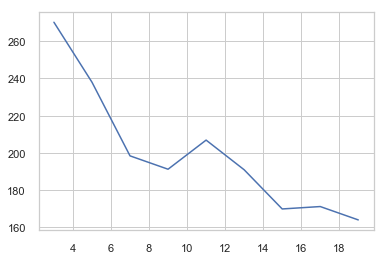

In [188]:
plt.plot(ks, chscores)

### Bisect Kmeans with LDA

In [147]:
csrL2Normalized_lda = hstack((csrL2Normalized, csrL2Normalized_lda)).tocsr()

In [148]:
csrL2Normalized_lda

<8580x126365 sparse matrix of type '<class 'numpy.float64'>'
	with 1193780 stored elements in Compressed Sparse Row format>

In [159]:
pca = TruncatedSVD(100)

In [160]:
csrL2Normalized_lda_pca = pca.fit_transform(csrL2Normalized_lda)

In [161]:
csrL2Normalized_lda_pca.shape

(8580, 100)

In [162]:
labels = train_model.bisecting_kmeans(csrL2Normalized_lda_pca, 7, 10)

In [163]:
pd.DataFrame(labels)[0].value_counts()

6    6762
2     819
1     607
3     170
5     140
4      82
Name: 0, dtype: int64